In [39]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from RegressionModel import RegressionModel
from NeuralNetwork import NeuralNetwork
from FFNN import FFNN
from Scheduler import *
from functions import *
plt.rcParams.update({'text.usetex': True, 'font.size': 18, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 16, 'ytick.labelsize': 16})

seed = 43

### Aims:
1. Use a simple one-dimensional polynomial function to compare the standard OLS and Ridge regression codes (from project 1), where we used the matrix inversion algorithm, with our own gradient descent (GD) and SGD codes.
2. Test a plain gradient descent with a fixed (but tuned) learning rate using the analytical expression for the gradient.
3. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Keep using the analytical expression for the gradient.
4. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from weeks 39 and 40 (decaying rate?). Discuss the results as functions of the various parameters (size of batches, number of epochs etc). Use the analytical gradient.
5. Implement the AdaGrad, RMSprop and ADAM methods for tuning the learning rate. Do this with and without momentum for plain gradient descent and SGD. Compare to no tuning and decaying rate?
6. Replace the analytical gradient with autograd.
7. Use the FFNN code to train the neural network and perform a regression analysis on the same data. Use different numbers of hidden layers and nodes, and test both sigmoid, ReLU and leaky ReLU as activation functions for the hidden layers. 
8. Always initialize the weights using a normal distribution, but make sure to test different ways of initializing the biases, and discuss these.
9. Remember to discuss the choice of cost function. 
10. Test results against similar code from scikit-learn, tensorflow/keras or pytorch.
11. Comment on the results and give a critical discussion of the results obtained with the linear regression code (when using matrix inversion?) and the neural network code.
12. Make an analysis of the regularization parameters and the learning rates employed to find the optimal MSE and R2 scores. Make some contourplots for this

In [40]:
n = 100
x = np.linspace(-3, 5, n).reshape(-1, 1)
coeffs = [2.0, 1.5, 0.5, 1.0]
y_true = f(x, coeffs)
y = y_true + np.random.normal(0.0, 20, (n, 1))

model = RegressionModel(x, y, 3, seed = seed)
X_scaled = model.scaler_X.transform(model.X)

### Comparing gradient descent with linear regression using matrix inversion

In [41]:
MSE_linreg, R2_linreg, theta_linreg = model.linear_regression(return_theta = True)
MSE_gd, R2_gd, theta_gd = model.gradient_descent(100, return_theta = True)
MSE_gd_mom, R2_gd_mom, theta_gd_mom = model.gradient_descent(100, gamma = 0.8, return_theta = True)
MSE_sgd, R2_sgd, theta_sgd = model.stochastic_gradient_descent(100, 10, return_theta = True)
MSE_sgd_mom, R2_sgd_mom, theta_sgd_mom = model.stochastic_gradient_descent(100, 10, gamma = 0.8, return_theta = True)

# Printing scores
print(f"                  |    MSE    |    R^2    |")
print(f"-------------------------------------------")
print(f"Linear regression |{MSE_linreg:8.3f}   |{R2_linreg:8.3f}   |")
print(f"GD w/o momentum   |{MSE_gd:8.3f}   |{R2_gd:8.3f}   |")
print(f"GD w/ momentum    |{MSE_gd_mom:8.3f}   |{R2_gd_mom:8.3f}   |")
print(f"SGD w/o momentum  |{MSE_sgd:8.3f}   |{R2_sgd:8.3f}   |")
print(f"SGD w/ momentum   |{MSE_sgd_mom:8.3f}   |{R2_sgd_mom:8.3f}   |")

                  |    MSE    |    R^2    |
-------------------------------------------
Linear regression |   0.256   |   0.686   |
GD w/o momentum   |   0.268   |   0.671   |
GD w/ momentum    |   0.256   |   0.686   |
SGD w/o momentum  |   0.275   |   0.662   |
SGD w/ momentum   |   0.292   |   0.642   |


In [42]:
y_linreg = model.scaler_y.inverse_transform(X_scaled @ theta_linreg)
y_gd = model.scaler_y.inverse_transform(X_scaled @ theta_gd)
y_gd_mom = model.scaler_y.inverse_transform(X_scaled @ theta_gd_mom)
y_sgd = model.scaler_y.inverse_transform(X_scaled @ theta_sgd)
y_sgd_mom = model.scaler_y.inverse_transform(X_scaled @ theta_sgd_mom)

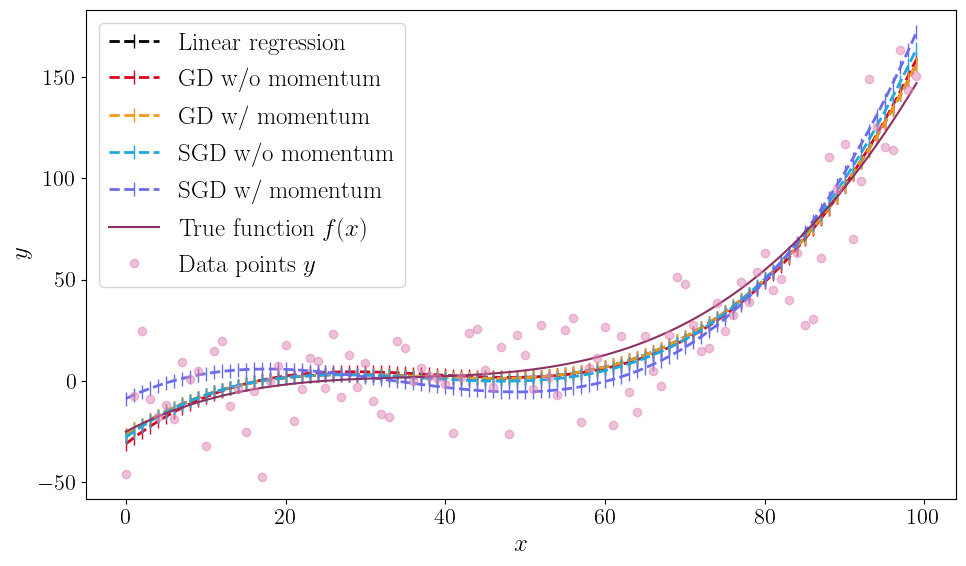

In [43]:
plt.figure(figsize = (10, 6))
plt.plot(y_linreg, "|--", color = "k", markersize = 10, linewidth = 2, label = "Linear regression")
plt.plot(y_gd, "|--", color = "#d60620", markersize = 10, linewidth = 2, label = r"GD w/o momentum")
plt.plot(y_gd_mom, "|--", color = "#f39919", markersize = 10, linewidth = 2, label = "GD w/ momentum")
plt.plot(y_sgd, "|--", color = "#20a7db", markersize = 10, linewidth = 2, label = r"SGD w/o momentum")
plt.plot(y_sgd_mom, "|--", color = "#6b6ced", markersize = 10, linewidth = 2, label = r"SGD w/ momentum")
plt.plot(y_true, color = "#8d3063", label = r"True function $f(x)$")
plt.plot(y, "o", color = "#de82b4", alpha = 0.5, label = r"Data points $y$")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.savefig("../figs/linreg_gd_sgd.pdf")
plt.show()

### Testing learning rates and momentum parameters

In [110]:
learning_rates = np.concatenate([[0], np.logspace(-3, 0, 19)])
momenta = np.linspace(0, 1, 20)

MSE_gd, MSE_sgd = np.ones((len(learning_rates), len(momenta))), np.ones((len(learning_rates), len(momenta)))
for i, eta in enumerate(learning_rates):
    for j, gamma in enumerate(momenta):
        try:
            MSE_gd[i, j] = model.gradient_descent(100, eta = eta, gamma = gamma)[0]
        except RuntimeWarning:
            print(eta, gamma)
        try:
            MSE_sgd[i, j] = model.stochastic_gradient_descent(100, 10, eta = eta, gamma = gamma)[0]
        except RuntimeWarning:
            print(eta, gamma)
            # continue

0.6812920690579608 0.0
0.6812920690579608 0.05263157894736842
0.6812920690579608 0.10526315789473684
0.6812920690579608 0.15789473684210525
0.6812920690579608 0.21052631578947367
0.6812920690579608 0.2631578947368421
0.6812920690579608 0.3157894736842105
0.6812920690579608 0.47368421052631576
0.6812920690579608 0.5263157894736842
0.6812920690579608 0.5789473684210527
0.6812920690579608 0.631578947368421
0.6812920690579608 0.6842105263157894
0.6812920690579608 0.7368421052631579
0.6812920690579608 0.7894736842105263
0.6812920690579608 0.8421052631578947
0.6812920690579608 0.894736842105263
0.6812920690579608 0.9473684210526315
0.6812920690579608 1.0
1.0 0.0
1.0 0.05263157894736842
1.0 0.10526315789473684
1.0 0.15789473684210525
1.0 0.21052631578947367
1.0 0.2631578947368421
1.0 0.3157894736842105
1.0 0.3684210526315789
1.0 0.42105263157894735
1.0 0.47368421052631576
1.0 0.5263157894736842
1.0 0.5789473684210527
1.0 0.631578947368421
1.0 0.6842105263157894
1.0 0.7368421052631579
1.0 0.78

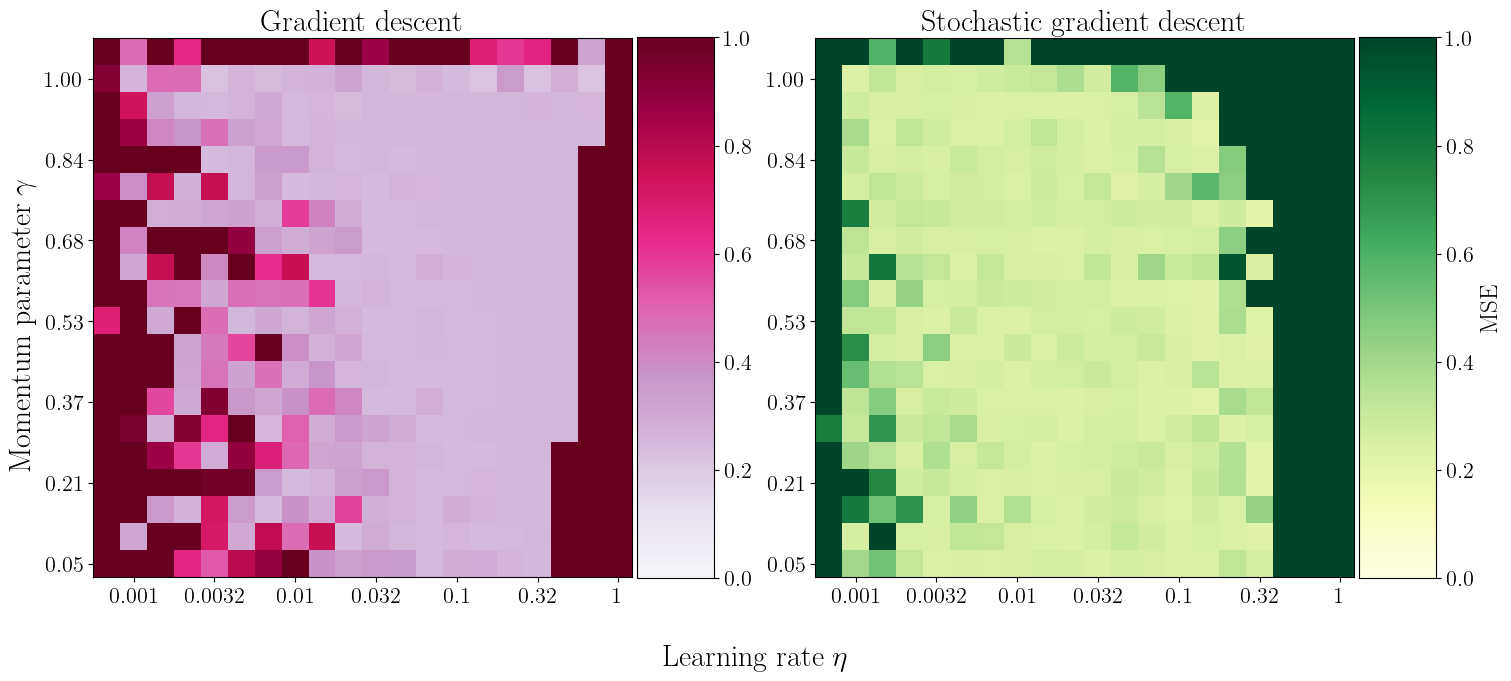

In [111]:
fig, axs = plt.subplots(1, 2, figsize = (15, 7), constrained_layout = True)
im1 = axs[0].imshow(MSE_gd.T[::-1], cmap = "PuRd", vmin = 0, vmax = 1)
im2 = axs[1].imshow(MSE_sgd.T[::-1], cmap = "YlGn", vmin = 0, vmax = 1)
plt.colorbar(im1, ax = axs[0], pad = 0.01, shrink = 0.823, aspect = 7)
plt.colorbar(im2, ax = axs[1], label = "MSE", pad = 0.01, shrink = 0.823, aspect = 7)
for i in range(2):
    axs[i].set_xticks([j for j in range(1, 20, 3)], labels = [f"{learning_rates[j]:.2g}" for j in range(1, 20, 3)])
    axs[i].set_yticks([j for j in range(1, 20, 3)], labels = [f"{momenta[j]:.2f}" for j in reversed(range(1, 20, 3))])
axs[0].set_title("Gradient descent")
axs[1].set_title("Stochastic gradient descent")
fig.supylabel(r"Momentum parameter $\gamma$")
fig.supxlabel(r"Learning rate $\eta$")
plt.savefig("../figs/eta_gamma.pdf")
plt.show()

### Comparing tuning methods: decaying learning rate, AdaGrad, RMSprop and ADAM

#### Plain gradient descent without momentum

#### Stochastic gradient descent with momentum

### Comparing the analytical gradient result with autograd

In [90]:
n = 100
x = np.linspace(-3, 5, n).reshape(-1, 1)
coeffs = [2.0, 1.5, 0.5, 1.0]
y_true = f(x, coeffs)
y = y_true + np.random.normal(0.0, 15, (n, 1))

In [91]:
model = RegressionModel(x, y, 3, seed = seed)
X_train, X_test, y_train, y_test = model.X_train, model.X_test, model.y_train, model.y_test

In [92]:
input_nodes = X_train.shape[1]
output_nodes = 1

#TODO why does error increase when using hidden layers?
linear_regression = FFNN((input_nodes, 6, output_nodes), hidden_func = identity, output_func = identity, cost_func = CostOLS, seed = seed)

In [93]:
linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

scheduler = Constant(eta = 1e-2)
scores = linear_regression.fit(X_train, y_train, scheduler)
print(scores)

Constant: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 0.169 {'train_errors': array([0.20107963, 0.19816398, 0.19564146, 0.19335214, 0.19127403,
       0.18938726, 0.18767382, 0.18611746, 0.18470343, 0.1834184 ,
       0.18225029, 0.18118818, 0.18022216, 0.17934326, 0.17854336,
       0.1778151 , 0.17715181, 0.17654745, 0.17599654, 0.17549411,
       0.17503566, 0.17461713, 0.1742348 , 0.17388533, 0.17356569,
       0.1732731 , 0.17300508, 0.17275935, 0.17253387, 0.17232677,
       0.17213636, 0.1719611 , 0.17179961, 0.17165062, 0.17151298,
       0.17138567, 0.17126774, 0.17115833, 0.17105667, 0.17096206,
       0.17087386, 0.17079148, 0.1707144 , 0.17064215, 0.17057429,
       0.17051043, 0.17045022, 0.17039332, 0.17033945, 0.17028834,
       0.17023974, 0.17019344, 0.17014924, 0.17010695, 0.17006641,
       0.17002747, 0.16999   , 0.16995387, 0.16991897, 0.1698852 ,
       0.16985246, 0.16982068, 0.16978976, 0.16975966, 0.16973029,
       0.1

In [94]:
y_pred = linear_regression.predict(X_test)

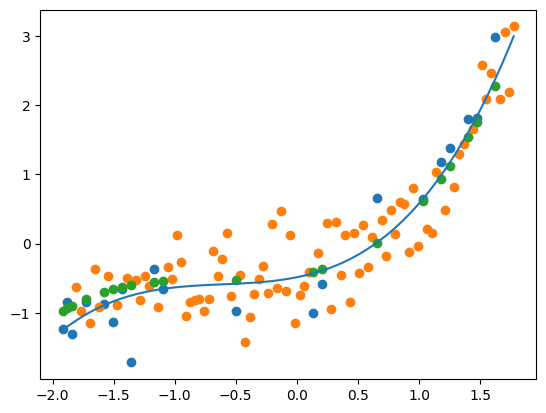

In [95]:
plt.scatter(X_test[:, 1], y_test)
plt.scatter(X_train[:, 1], y_train)
plt.scatter(X_test[:, 1], y_pred)
plt.plot(model.scaler_X.transform(model.X)[:, 1], model.scaler_y.transform(y_true))